# Importing libraries

In [1]:
import numpy as np
import pysindy as ps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit 
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data Processing

In [2]:
df = pd.read_csv("DNS_Data_PCA_PySINDy.csv")
# Select the specific DataFrame columns needed for PySINDy or PINNs
df = df[["y^+","U","Re_tau","PC1","PC2","P","dU/dy"]]
Reynolds_Number = df["Re_tau"].unique() # Obtain the different Reynolds numbers
df

,y^+,U,Re_tau,PC1,PC2,P,dU/dy
0,0.000000,0.000000,5185.897,-3.910347,0.657459,0.000000,1.000000
1,0.518124,0.518066,5185.897,-3.869397,0.684328,-0.000016,0.999702
2,1.036249,1.035755,5185.897,-3.761768,0.759708,-0.000173,0.998367
3,1.554373,1.552302,5185.897,-3.598314,0.880914,-0.000695,0.995003
4,2.072498,2.066162,5185.897,-3.382573,1.048359,-0.001888,0.988395
...,...,...,...,...,...,...,...
49995,180.486137,18.268216,182.088,-2.641824,0.042917,-0.378819,0.000670
49996,180.504194,18.268239,182.088,-2.642025,0.042928,-0.378816,0.000662
49997,180.522252,18.268262,182.088,-2.642226,0.042939,-0.378813,0.000655
49998,180.540310,18.268285,182.088,-2.642427,0.042949,-0.378809,0.000647


             y^+         U    Re_tau           PC1           PC2         P  \
y^+     1.000000  0.738984  0.776980 -3.203259e-01 -1.954858e-01  0.142508   
U       0.738984  1.000000  0.621793 -2.816455e-01 -5.919237e-01 -0.083107   
Re_tau  0.776980  0.621793  1.000000  1.725137e-01 -2.145719e-01 -0.309404   
PC1    -0.320326 -0.281646  0.172514  1.000000e+00 -1.541994e-16 -0.875527   
PC2    -0.195486 -0.591924 -0.214572 -1.541994e-16  1.000000e+00  0.474235   
P       0.142508 -0.083107 -0.309404 -8.755273e-01  4.742352e-01  1.000000   
dU/dy  -0.202809 -0.694136 -0.183606 -6.567313e-02  6.822578e-01  0.391585   

           dU/dy  
y^+    -0.202809  
U      -0.694136  
Re_tau -0.183606  
PC1    -0.065673  
PC2     0.682258  
P       0.391585  
dU/dy   1.000000  


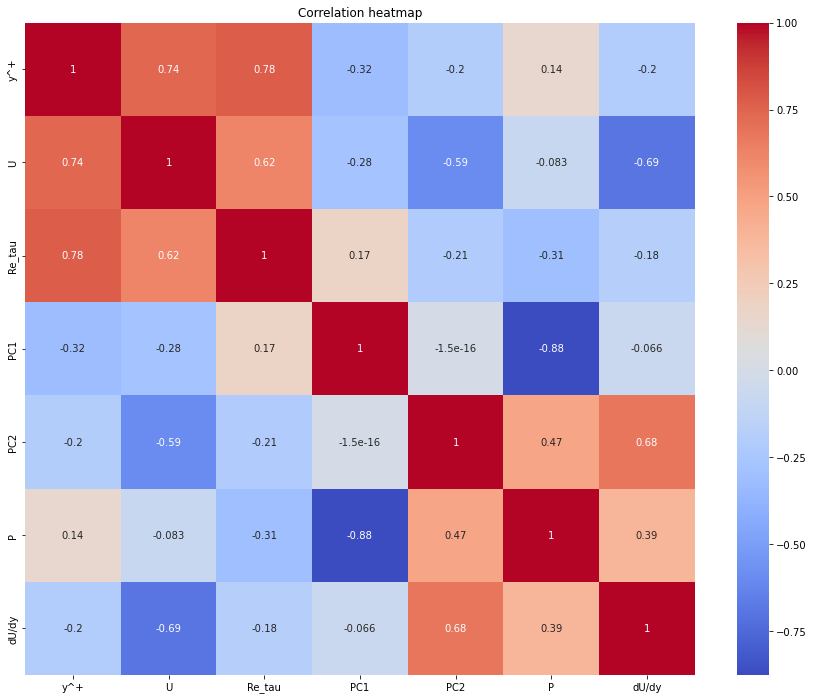

In [3]:
# Calculate the correlation matrix for the DataFrame and display it in the form of a heatmap
corr = df.corr()
print(corr)
plt.figure(figsize=(15,12))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation heatmap")
plt.show()

In [4]:
def first_derivative(columns,df):
    """
    Compute the first derivative of the specified columns.
    
    Args:
        columns (list): List of column names in the dataframe for which the first derivative is to be calculated
        df (pd.DataFrame): The dataframe containing the DNS data
       
    Returns:
        pd.DataFrame: The input dataframe with the additional columns representing the first derivative 
        of the columns present in the list (columns)
    """
    for col in columns:  
        # Extract the data from a column and y^+ into numpy arrays
        x = df[col].to_numpy()
        y = df["y^+"].to_numpy()
        
        # Calculate the first derivative of the column with respect to y^+
        dx = np.gradient(x,y)
        
        # Store the result of the first derivative of the column in the dataframe
        df["d" + col + "/dy"] = dx
        
    return df

def second_derivative(columns,df):
    """
    Compute the second derivative of the specified columns.
    
    Args:
        columns (list): List of column names in the dataframe for which the second derivative is to be calculated
        df (pd.DataFrame): The dataframe containing the DNS data
       
    Returns:
        pd.DataFrame: The input dataframe with the additional columns representing the second derivative 
        of the columns present in the list (columns)
    """
    for col in columns: 
        # Extract the data from a column and y^+ into numpy arrays
        x = df[col].to_numpy()
        y = df["y^+"].to_numpy()
        
        # Calculate the first derivative of the column with respect to y^+
        dx = np.gradient(x,y)
        
        # Store the result of the first derivative of the column in the dataframe
        df["d(" + col + ")/dy"] = dx
        
    return df

def data_PCA_processing(df, Reynolds_Number):
    """
    Process the dataframe to have the first and second derivative.
    
    Args:
        df (pd.DataFrame): The dataframe containing the DNS data
        Reynolds_Numbers (list): The list of Reynolds numbers
    
    Returns:
        dict: The processed data
    """
    
    # Dictionary containing dataframes associated with a specific number of reynolds
    data = {f'df_{Re}': df[df["Re_tau"] == Re] for Re in Reynolds_Number}
    
    # Calculate the first and second derivatives of the specified columns for each dataframe in the dictionary
    for Re in Reynolds_Number:
        
        columns_to_derive = ["PC1","PC2","P"]
        data[f"df_{Re}"] = first_derivative(columns_to_derive,data[f"df_{Re}"])
        
        columns_to_derive = ["dU/dy","dPC1/dy", "dPC2/dy","dP/dy"]
        data[f"df_{Re}"] = second_derivative(columns_to_derive,data[f"df_{Re}"])
        
    return data

In [5]:
data = data_PCA_processing(df,Reynolds_Number)

C:\Users\moi\AppData\Local\Temp/ipykernel_201864/2551907546.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["d" + col + "/dy"] = dx
C:\Users\moi\AppData\Local\Temp/ipykernel_201864/2551907546.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["d(" + col + ")/dy"] = dx


In [6]:
def data_PCA_PySINDy(data,Reynolds_Number):
    """
    Prepare the data for PySINDy
   
    Args:
        data (dict): The processed data
        Reynolds_Numbers (list): The list of Reynolds numbers
    
    Returns:
        list: The input data (containing the feature variables)
        list: The output data (containing the target variables)
    """
    # Initialise the lists containing the feature variables (X) and target variables (y) for each Reynolds number
    X = [[] for _ in range(len(Reynolds_Number))]
    y = [[] for _ in range(len(Reynolds_Number))]
    
    for i in range(0,len(Reynolds_Number)):
        # Extract the feature variables 
        X[i] = data[f"df_{Reynolds_Number[i]}"].drop(columns=["y^+","Re_tau","d(dU/dy)/dy","d(dPC1/dy)/dy", "d(dPC2/dy)/dy","d(dP/dy)/dy"]).values
        
        # Extract the target variables 
        y[i] = data[f"df_{Reynolds_Number[i]}"][["dU/dy", "dPC1/dy", "dPC2/dy","dP/dy","d(dU/dy)/dy","d(dPC1/dy)/dy", "d(dPC2/dy)/dy","d(dP/dy)/dy"]].values
    
    return X,y

In [7]:
X,y = data_PCA_PySINDy(data,Reynolds_Number)

# PySINDy Model

In [8]:
# Select the DNS data of the Reynolds Number 5200 for the training data and the DNS data of the Reynolds Number 2000 for the test data
X_train = X[0]
y_train = y[0]
X_test = X[1]
y_test = y[1]

### Training of the PySINDy Model

In [9]:
# Define the names of the elements that are going to be used in the model
feature_names = ["U","PC1", "PC2","P","dU/dy", "dPC1/dy", "dPC2/dy","dP/dy"]

# Set the feature_library parameter
feature_library = ps.PolynomialLibrary(1)

print("\n*********************************")
print(f"Reynolds Number = {Reynolds_Number[0]}")
print("PysINDy Model:")

# Define the STLSQ optimizer and its parameters
optimizer = ps.STLSQ(threshold=0.001,alpha=0.0001)

# Create the SYNDy model with the specified parameters 
model = ps.SINDy(feature_library=feature_library,optimizer=optimizer,feature_names=feature_names)

# Fit the model on the training data
model.fit(X_train,x_dot = y_train)

# Display the equations of the PySINDY model
model.print()


*********************************
Reynolds Number = 5185.897
PysINDy Model:
(U)' = 1.000 dU/dy
(PC1)' = 1.000 dPC1/dy
(PC2)' = 1.000 dPC2/dy
(P)' = 1.000 dP/dy
(dU/dy)' = 0.022 dU/dy + -0.233 dPC1/dy + 0.141 dPC2/dy + -0.611 dP/dy
(dPC1/dy)' = -0.012 1 + -0.002 PC1 + -0.003 PC2 + -0.014 P + 0.266 dU/dy + -0.622 dPC1/dy + 0.351 dPC2/dy + -1.933 dP/dy
(dPC2/dy)' = -0.010 1 + -0.002 PC1 + -0.004 PC2 + -0.011 P + 0.242 dU/dy + -0.647 dPC1/dy + 0.349 dPC2/dy + -2.433 dP/dy
(dP/dy)' = -0.012 dPC1/dy + 0.005 dPC2/dy + -0.084 dP/dy


### Evaluation of the PySINDy Model

In [10]:
# Use the model to predict values based on the test features
y_pred = model.predict(X_test)
y_true = y_test

# Compute the R-squared value
r2 = r2_score(y_true, y_pred)
print(f"R-square: {r2}")

# Compute the MSE value
mse = mean_squared_error(y_true, y_pred)
print(f"MSE: {mse}")

R-square: 0.8876720412130256
MSE: 4.472204113957067e-06


In [11]:
def test_overfitting(X_train,y_train,X_test,y_test,model):
    """
    Test if the model is overfitting.
    
    Args:
        X_train (list): The input training data
        y_train (list): The output training data
        X_test (list): The input testing data
        y_test (list): The output testing data
        model (dict): The PySINDy model

    Returns:
        None
    """
    
    # Use the model to predict values based on the train features
    y_train_pred =  model.predict(X_train)
    # Compute the train MSE value
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    # Use the model to predict values based on the train features
    y_test_pred =  model.predict(X_test)
    # Compute the test MSE value
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    print(f"MSE Training: {mse_train}")
    print(f"MSE Test: {mse_test}")
    
    # Check that there is no overfitting by comparing the training and test MSEs
    if abs(mse_train - mse_test) > 0.001:
        print("PySINDy Model - Overfitting!")
    else:
         print("PySINDy Model - No Overfitting!")

In [12]:
test_overfitting(X_train,y_train,X_test,y_test,model)

MSE Training: 1.0794386229297175e-06
MSE Test: 4.472204113957067e-06
PySINDy Model - No Overfitting!


### PySINDy Simulation

In [13]:
def integrate(y_plus, y, coeffs):    
    """
    Computes the derivatives at a point for integration.

    Args:
        y_plus (float): The spatial variable for the integration
        y (array): Current state variables
        coeffs (array): Coefficients of the trained PySINDy Model

    Returns:
        list: Derivatives of the state variables and their second derivatives
    """
    
    # Initialise a variable to store the derivatives
    derivatives = []
    
    # Calculate the derivative for each state variable using the coefficients of the trained PySINDy Model
    for i in range(len(y)):
        dd = coeffs[i][0] + np.dot(coeffs[i][1:], y) 
        derivatives.append(dd)
    
    return derivatives


def simulation(X, df, model):
    """
    Simulate the PySINDy model using numerical integration.
    
    Args:
        X (list): The input data
        df (pd.DataFrame): The dataframe containing the DNS data
        model (object): The trained PySINDy Model
        
    Returns:
        OdeResult: The result of the simulation
    """
    
    # Extract the initial conditions 
    initial_conditions = X[0]
    
    # Extract the coefficients of the PySINDy Model
    coeffs = model.optimizer.coef_
    
    # Extract the y^+ values of the dataframe
    y_plus_points = df["y^+"].values
    
    # Run the integration over the range of y^+ points
    solution = solve_ivp(
        fun=integrate, 
        t_span=(y_plus_points.min(), y_plus_points.max()), 
        y0=initial_conditions, 
        args=(coeffs,), 
        t_eval=y_plus_points,  
        method='RK45',
        dense_output = True
    )
    
    return solution

In [14]:
#Simulate the PySINDy model for DNS data associated with the Reynolds number 2000
solution = simulation(X_test, data["df_1994.756"], model)

In [15]:
def simulation_PCA_plot(df, solution):
    """
    Plot the simulation
    
    Args:
        df (pd.DataFrame): The dataframe containing the DNS data
        solution (scipy.integrate._ivp.ivp.OdeSolution): The solutions of the PySINDy Simulation

    Returns:
        None
    """
    col = ["U","PC1","PC2"]
    
    for i in range(3):
        
        plt.figure(figsize=(12, 6))
        
        # Extract the y^+ values of the dataframe
        y = df['y^+'].values
        
        subset_pred = solution.y[i]
        subset_target = df[col[i]]
        
        # Plot predictions and DNS data
        plt.plot(solution.t, subset_pred,color="blue",linestyle="-",label = f"{col[i]} (PySINDy_PCA)")
        plt.plot(y, subset_target.values, color="red",linestyle="--",label=f"{col[i]} (DNS)")
        
        plt.xscale('log')
        plt.xlim(left=0.1, right = 10000)
        plt.xlabel('y^+')
        
        plt.ylabel(col[i])
        plt.title(f"{col[i]} Prediction vs. DNS")
        
        plt.legend()
        plt.plot()

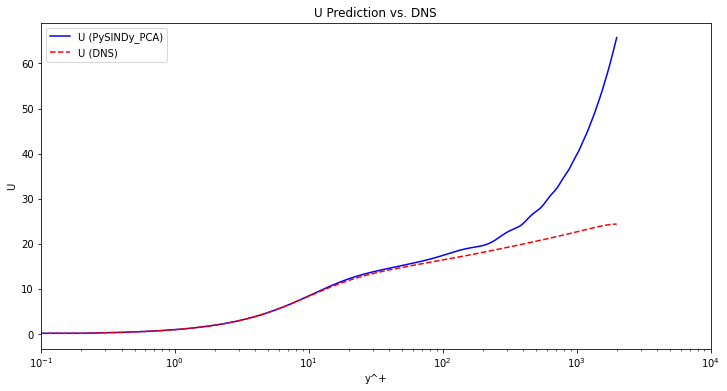

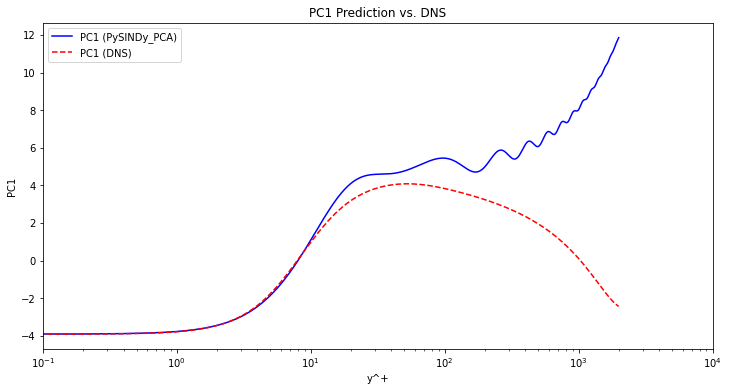

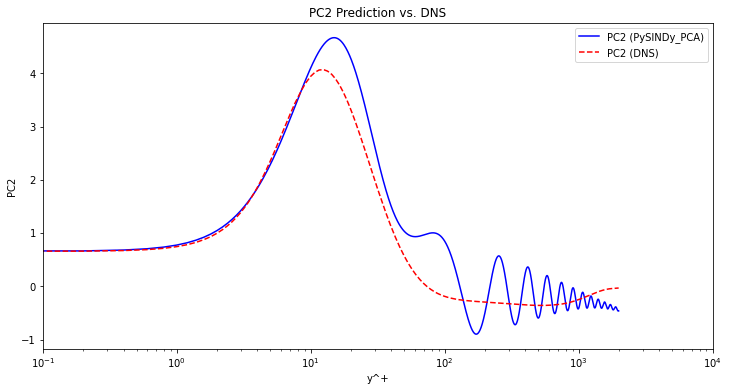

In [16]:
simulation_PCA_plot(data["df_1994.756"], solution)

In [17]:
# Create a dataframe from the simulation results
df_sim_PCA = pd.DataFrame({"y^+":solution.t,'U': solution.y[0], "PC1": solution.y[1], "PC2": solution.y[2]})
df_pred = data["df_1994.756"][data["df_1994.756"]['y^+'].isin(solution.t)]
# Compute the MAE between simulation results and DNS data 
mae_sim_PCA = mean_absolute_error( df_pred[["U","PC1","PC2"]].values,df_sim_PCA[["U","PC1","PC2"]].values)
print(f"MAE: {mae_sim_PCA}")

MAE: 8.689249703950258


In [18]:
df_sim_PCA.to_csv("prediction_output_pysindy_pca.csv",index=False)